In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext Cython

In [3]:
%%cython -l gsl
# Include the right header file and declare the function
cdef extern from "gsl/gsl_sf_bessel.h":
    double gsl_sf_bessel_J0(double x)

# small python wrapper to give it a nicer name
def bessel_J0(double x):
    return gsl_sf_bessel_J0(x)

In [4]:
%%cython -l gsl
from cpython.mem cimport PyMem_Malloc, PyMem_Free

# Declare the few types and functions we need
cdef extern from "gsl/gsl_qrng.h":
    ctypedef struct gsl_qrng
    ctypedef struct gsl_qrng_type
    gsl_qrng_type* gsl_qrng_sobol
    
    gsl_qrng* gsl_qrng_alloc(gsl_qrng_type* T, unsigned int d)
    void gsl_qrng_free(gsl_qrng* q)
    
    int gsl_qrng_get(const gsl_qrng * q, double x[])

# This is the wrapper class
cdef class Sobol:
    cdef gsl_qrng* _q
    cdef unsigned _D
    cdef double *_v
    def __cinit__(self, D=1):
        """Create a `D` dimensional Sobol sequence."""
        self._D = D
        
        # gsl_qrng_get() returns the next
        # value in one of its arguments
        self._v = <double *>PyMem_Malloc(D * sizeof(double))
        if not self._v:
            raise MemoryError()
        
        # Actually allocate the QRNG generator
        self._q = gsl_qrng_alloc(gsl_qrng_sobol, D)
        if self._q is NULL:
            raise MemoryError()
        
    def get(self, int N=1):
        """The next `N` points in the sequence."""
        points = []
        for n in xrange(N):
            points.append(self.__next__())
            
        return points
        
    def __next__(self):
        """Iterate over the sequence."""
        gsl_qrng_get(self._q, self._v)
        return [self._v[i] for i in xrange(self._D)]
    
    def __iter__(self):
        return self
    
    # Make sure we free all the memory we allocated
    def __dealloc__(self):
        if self._q is not NULL:
            gsl_qrng_free(self._q)
            
        PyMem_Free(self._v)

In [7]:
sobol2d = Sobol(2)

In [9]:
from scipy.stats.distributions import uniform, norm

In [12]:
uniform.pdf(0.2)

1.0

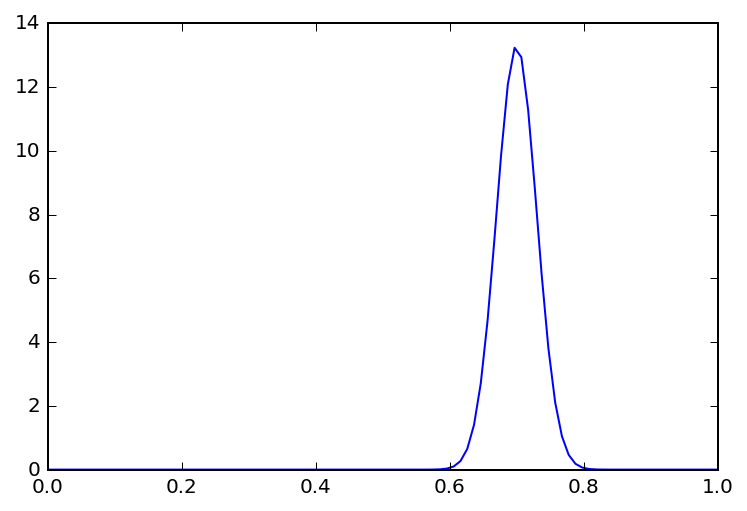

In [20]:
x = np.linspace(0,1, 100)
plt.plot(x, norm(0.7, 0.03).pdf(x))